In [1]:
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt
import pandas as pd
import copy
import os
import sys
import networkx as nx
import seaborn as sns
sns.set(style='darkgrid')
sns.set_style(style='whitegrid')

In [2]:
# moduleー
current_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append( str(current_dir) + '/../' )

In [3]:
from setting_param import MakeSample_prediction_num_of_edge_InputDir, MakeSample_prediction_num_of_edge_OutputDir
from setting_param import L
InputDir = MakeSample_prediction_num_of_edge_InputDir
OutputDir = MakeSample_prediction_num_of_edge_OutputDir

In [4]:
os.mkdir(OutputDir)

os.mkdir(OutputDir + "/input/")
os.mkdir(OutputDir + "/input/new")
os.mkdir(OutputDir + "/input/appeared")
os.mkdir(OutputDir + "/input/disappeared")

os.mkdir(OutputDir + "/label/")
os.mkdir(OutputDir + "/label/new")
os.mkdir(OutputDir + "/label/appeared")
os.mkdir(OutputDir + "/label/disappeared")

In [5]:
# READ EXIST_TABLE
EXIST_TABLE = np.load(InputDir + '/exist_table.npy')
EXIST_TABLE.shape

(3859, 68)

In [6]:
def ExistNodeList(ts):
    assert ts >= 0, "ts < 0 [referrence error]"
    return np.where(EXIST_TABLE[:, ts]==1)[0]

def GetAppearedNodes(ts):
    return set(ExistNodeList(ts)) - set(ExistNodeList(ts-1))

def GetObservedNodes(ts, L):
    U = set()
    for i in range(L):
        U |= set(ExistNodeList(ts-i))
    return U

def GetNodes(ts, L, node_type):
    if node_type=='all':
        node_set = set(ExistNodeList(ts))
    elif node_type=='stay':
        node_set = set(ExistNodeList(ts-1)) & set(ExistNodeList(ts))
    elif node_type=='lost':
        node_set = set(ExistNodeList(ts-1)) - set(ExistNodeList(ts))
    elif node_type=='return':
        node_set = GetAppearedNodes(ts) - (GetAppearedNodes(ts) - GetObservedNodes(ts-1, L))
    elif node_type=='new':
        node_set = GetAppearedNodes(ts) - GetObservedNodes(ts-1, L)
        node_set |= GetNodes(ts, L, 'return')
    return node_set

In [7]:
def Nx(ts):
    return  nx.from_numpy_matrix(np.load(InputDir + '/adjacency' + str(ts) + '.npy'))

def SubNxNew(ts, L):
    return nx.Graph(Nx(ts).edges(GetNodes(ts, L, 'new')))

def SubNxLost(ts, L):
    return nx.Graph(Nx(ts-1).edges(GetNodes(ts, L, 'lost')))

def GetEdges(ts, L, edge_type):
    G_1 = Nx(ts)
    if edge_type == "all":
        edge_set = G_1.edges
    elif edge_type == 'stay':
        G_0 = Nx(ts - 1)
        edge_set = G_0.edges & G_1.edges
    elif edge_type == "appeared":
        G_0 = Nx(ts - 1)
        edge_set = G_1.edges - G_0.edges - SubNxNew(ts, L).edges
    elif edge_type == "disappeared":
        G_0 = Nx(ts - 1)
        edge_set = G_0.edges - G_1.edges - SubNxLost(ts, L).edges
    return edge_set

In [8]:
def TsSplit(ts, L):
    ts_train = [(ts+l) for l in range(L)]
    ts_test = ts_train[-1]+1
    ts_all = ts_train.copy()
    ts_all.extend([ts_test])
    return ts_train, ts_test, ts_all

In [9]:
for ts in range(L, EXIST_TABLE.shape[1]-L):
    ts_train, ts_test, ts_all = TsSplit(ts, L)
    new = []
    disappeared = []
    appeared = []
    for ts_ in ts_train:
        new.append(len(SubNxNew(ts_, L).edges))
        disappeared.append(len(GetEdges(ts_, L, 'disappeared')))
        appeared.append(len(GetEdges(ts_, L, 'appeared')))
    np.save(OutputDir + "/input/new/" + str(ts), new)
    np.save(OutputDir + "/input/disappeared/" + str(ts), disappeared)
    np.save(OutputDir + "/input/appeared/" + str(ts), appeared)
    np.save(OutputDir + "/label/new/" + str(ts), [len(SubNxNew(ts_test, L).edges)])
    np.save(OutputDir + "/label/disappeared/" + str(ts), [len(GetEdges(ts_test, L, 'disappeared'))])
    np.save(OutputDir + "/label/appeared/" + str(ts), [len(GetEdges(ts_test, L, 'appeared'))])

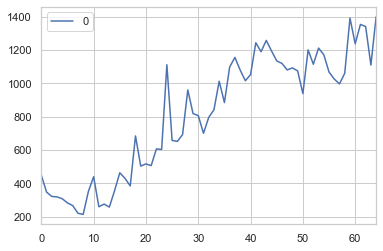

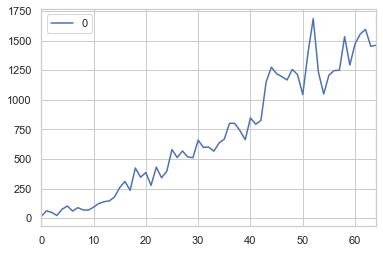

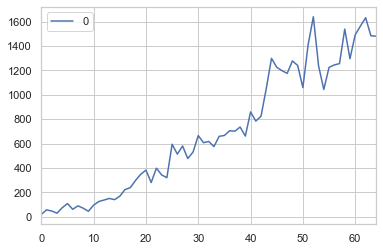

In [10]:
new = []
disappeared = []
appeared = []

for ts in range(L, EXIST_TABLE.shape[1]):
    new.append(len(SubNxNew(ts, L).edges))
    disappeared.append(len(GetEdges(ts, L, 'disappeared')))
    appeared.append(len(GetEdges(ts, L, 'appeared')))

df_new = pd.DataFrame(new)
df_new.plot()

df_disappeared = pd.DataFrame(disappeared)
df_disappeared.plot()

df_appeared = pd.DataFrame(appeared)
df_appeared.plot()

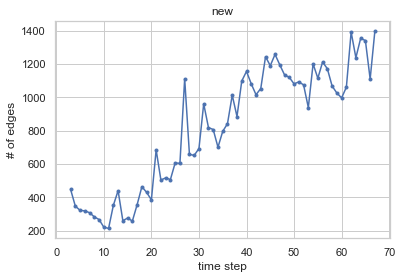

In [11]:
plt.plot([ts for ts in range(L, EXIST_TABLE.shape[1])], new, marker=".")
plt.title('new')
plt.xlabel('time step')
plt.ylabel('# of edges')
plt.savefig('statistics/num_of_edges/new.pdf')

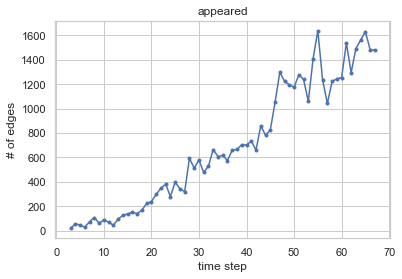

In [12]:
plt.plot([ts for ts in range(L, EXIST_TABLE.shape[1])], appeared, marker=".")
plt.title('appeared')
plt.xlabel('time step')
plt.ylabel('# of edges')
plt.savefig('statistics/num_of_edges/appeared.pdf')

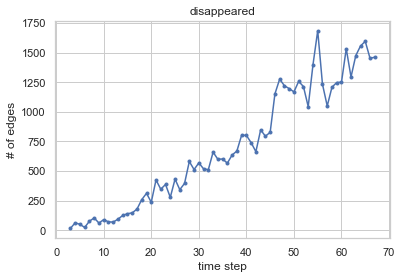

In [13]:
plt.plot([ts for ts in range(L, EXIST_TABLE.shape[1])], disappeared, marker=".")
plt.title('disappeared')
plt.xlabel('time step')
plt.ylabel('# of edges')
plt.savefig('statistics/num_of_edges/disappeared.pdf')

In [14]:
max(appeared), min(appeared)

(1639, 19)

In [15]:
max(disappeared), min(disappeared)

(1685, 15)

In [16]:
max(new), min(new)

(1399, 213)